In [1]:
import numpy as np

import tensorflow as tf
from mnist_dataset import Dataset

In [2]:
class GAN:
    
    def __init__(self, x_size, y_size, z_size):
        self.x_size = x_size
        self.y_size = y_size
        self.z_size = z_size
    
        self.__build()
    
    def __build(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.__placeholders()
            
            # generator
            z = tf.random_uniform((tf.shape(self.X_lab)[0], self.z_size))
            g_model = self.__get_generator(z)
            
            # discriminators
            d_lab = self.__get_discriminator(self.X_lab)
            d_unl = self.__get_discriminator(self.X_unl, True)
            d_fake = self.__get_discriminator(g_model, True)
            
            # losses
            ## Discriminator Loss
            y_one_hot = tf.one_hot(self.y, 10)
            loss_lab = tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_lab, labels=y_one_hot)
            loss_lab = tf.reduce_mean(loss_lab)
            
            l_unl = tf.reduce_logsumexp(d_unl, axis=1)
            l_gen = tf.reduce_logsumexp(d_fake, axis=1)
            loss_unl = -.5*tf.reduce_mean(l_unl) + \
                        .5*tf.reduce_mean(tf.nn.softplus(l_unl)) + \
                        .5*tf.reduce_mean(tf.nn.softplus(l_gen))
            
            self.loss_disc = loss_lab + loss_unl
            
            ## Generator Loss
            self.loss_gen = -tf.reduce_mean(tf.nn.softplus(l_gen))
            
            # optimizer
            t_vars = tf.trainable_variables()
            g_vars = [var for var in t_vars if var.name.startswith('generator')]
            d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
            
            self.opt_disc = tf.train.AdamOptimizer(self.eta, .5).minimize(self.loss_disc, var_list=d_vars)
            self.opt_gen  = tf.train.AdamOptimizer(self.eta, .5).minimize(self.loss_gen, var_list=g_vars)
        
            self.predict = d_lab
            self.generator = self.__get_generator(z, True)
    
    def __placeholders(self):
        self.X_lab = tf.placeholder(tf.float32, [None, self.x_size], 'X')
        self.X_unl = tf.placeholder(tf.float32, [None, self.x_size], 'X_')
        self.y = tf.placeholder(tf.int32, [None, self.y_size], 'y')
        
        self.eta = tf.placeholder(tf.float32, name='learning_rate')
        self.is_training = tf.placeholder(tf.bool, name='is_training')
    
    def __get_generator(self, tensor, reuse=False):
        with tf.variable_scope('generator', reuse=reuse):
            tensor = tf.layers.dense(tensor, 500, tf.nn.softplus)
            tensor = tf.layers.batch_normalization(tensor, training=self.is_training)
            
            tensor = tf.layers.dense(tensor, 500, tf.nn.softplus)
            tensor = tf.layers.batch_normalization(tensor, training=self.is_training)
            
            tensor = tf.layers.dense(tensor, self.x_size, tf.nn.sigmoid)
        return tf.nn.l2_normalize(tensor, axis=1)
    
    def __get_discriminator(self, tensor, reuse=False):
        with tf.variable_scope('discriminator', reuse=reuse):
            tensor = self.__add_noise(tensor, .3)
            
            tensor = tf.layers.dense(tensor, 1000, tf.nn.relu)
            tensor = self.__add_noise(tensor, .5)
            
            tensor = tf.layers.dense(tensor, 500, tf.nn.relu)
            tensor = self.__add_noise(tensor, .5)
            
            tensor = tf.layers.dense(tensor, 250, tf.nn.relu)
            tensor = self.__add_noise(tensor, .5)
            
            tensor = tf.layers.dense(tensor, 250, tf.nn.relu)
            tensor = self.__add_noise(tensor, .5)
            
            tensor = tf.layers.dense(tensor, 250, tf.nn.relu)
            tensor = self.__minibatch(tensor, 100, 5)
            
            tensor = tf.layers.dense(tensor, 10)
        return tensor
    
    def __add_noise(self, tensor, mu=0., std=1.):
        noise = lambda: tensor + tf.random_normal(tf.shape(tensor), stddev=std)
        no_noise = lambda: tensor
        return tf.cond(self.is_training, noise, no_noise)
    
    def __minibatch(self, f, B, C):
        _, A = f.get_shape()
        T = tf.get_variable("T", [A, B, C])
        
        M = tf.tensordot(f, T, [[1], [0]])
        abs_dif = tf.reduce_sum(tf.abs(M[:,:,:,None] - tf.reshape(M, (1, B, C, -1))), axis=2)
        result = tf.reduce_sum(tf.exp(-abs_dif), axis=2)
        
        result += tf.get_variable("b", B)
        return tf.concat([f, result], axis=1)
    
model = GAN(784, 1, 100)

# Training the model

In [3]:
SAMPLE_SIZE = 1000
ix = np.random.choice(range(42000), SAMPLE_SIZE)
not_in_ix = [i for i in range(42000) if i not in ix]

dataset = Dataset('mnist_dataset/')
X = dataset.train['images'][ix]
y = dataset.train['labels'][ix]

X_un = dataset.train['images'][not_in_ix]

In [4]:
def next_batch(X, y, batch_size):
    ix = np.random.choice(len(X), batch_size)
    return X[ix], y[ix]

def next_batch_(X, batch_size):
    ix = np.random.choice(len(X), batch_size)
    return X[ix]

In [5]:
epochs = 100

train_size = len(X)
batch_size = 100

model = GAN(784, 1, 100)
model_name = 'mnist_minibatch_dicrimination'

with tf.Session(graph=model.graph) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, f'./models/{model_name}')
    
    for epoch in range(epochs):
        d_losses, g_losses = list(), list()
        for _ in range(train_size//batch_size):
            x_batch, y_batch = next_batch(X, y, batch_size)
            un_batch = next_batch_(X_un, batch_size)
            
            feed_dict = dict()
            feed_dict[model.X_lab] = x_batch
            feed_dict[model.X_unl] = un_batch
            feed_dict[model.y] = y_batch
            feed_dict[model.eta] = 3e-4
            feed_dict[model.is_training] = True
            
            d_loss, _ = sess.run([model.loss_disc, model.opt_disc], feed_dict)
            for _ in range(3):
                g_loss, _ = sess.run([model.loss_gen, model.opt_gen], feed_dict)
            
            d_losses.append(d_loss); g_losses.append(g_loss)
            print(f'\rEpoch {epoch+1:3}/{epochs:3} - DLoss: {d_loss:.6f} - GLoss: {g_loss:.6f}', end='')
        print(f'\rEpoch {epoch+1:3}/{epochs:3} - DLoss: {np.mean(d_losses):.6f} - GLoss: {np.mean(g_losses):.6f}', end='')
        if (epoch+1) % 5 == 0:
            print('')
    
    saver.save(sess, f'./models/{model_name}')

INFO:tensorflow:Restoring parameters from ./models/mnist_minibatch_dicrimination
Epoch   5/100 - DLoss: 0.595423 - GLoss: -0.005160
Epoch  10/100 - DLoss: 0.623902 - GLoss: -0.003576
Epoch  15/100 - DLoss: 0.614636 - GLoss: -0.006500
Epoch  20/100 - DLoss: 0.602942 - GLoss: -0.004187
Epoch  25/100 - DLoss: 0.554387 - GLoss: -0.006278
Epoch  30/100 - DLoss: 0.552076 - GLoss: -0.003537
Epoch  35/100 - DLoss: 0.580890 - GLoss: -0.003542
Epoch  40/100 - DLoss: 0.568641 - GLoss: -0.004120
Epoch  45/100 - DLoss: 0.556497 - GLoss: -0.003934
Epoch  50/100 - DLoss: 0.553006 - GLoss: -0.005300
Epoch  55/100 - DLoss: 0.599631 - GLoss: -0.005363
Epoch  60/100 - DLoss: 0.518967 - GLoss: -0.005372
Epoch  65/100 - DLoss: 0.513203 - GLoss: -0.004253
Epoch  70/100 - DLoss: 0.530952 - GLoss: -0.004659
Epoch  75/100 - DLoss: 0.563850 - GLoss: -0.003493
Epoch  80/100 - DLoss: 0.558674 - GLoss: -0.002711
Epoch  85/100 - DLoss: 0.563121 - GLoss: -0.004888
Epoch  90/100 - DLoss: 0.453384 - GLoss: -0.006198
E

In [20]:
model = GAN(784, 1, 100)
model_name = 'mnist_minibatch_dicrimination'

with tf.Session(graph=model.graph) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, f'./models/{model_name}')
    
    feed_dict = dict()
    feed_dict[model.X_lab] = dataset.test['images'][:10]
    feed_dict[model.is_training] = False
    
    result = sess.run(model.predict, feed_dict)
    
    feed_dict[model.X_lab] = dataset.test['images'][0,None]
    img = sess.run(model.generator, feed_dict)
np.argmax(result, axis=1)

INFO:tensorflow:Restoring parameters from ./models/mnist_minibatch_dicrimination


array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

In [7]:
import matplotlib.pyplot as plt

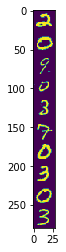

In [8]:
plt.imshow(dataset.test['images'][:10].reshape(-1, 28))

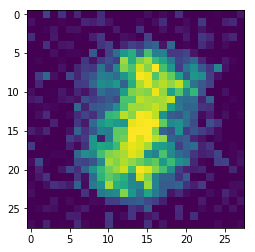

In [21]:
plt.imshow(img.reshape(-1, 28))